In [1]:
pip install pandas numpy matplotlib seaborn openpyxl

Note: you may need to restart the kernel to use updated packages.


In [31]:
import pandas as pd

file_path = "C:/Users/mgsma/OneDrive/Documentos/MeusProjetos/segmentacao_e_personalizacao_de_clientes/dataset/online_retail_II.xlsx"
data = pd.read_excel(file_path, sheet_name='Year 2010-2011', engine='openpyxl')

data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [34]:
#data.info()

#data.isnull().sum()

data.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,392693.000000,392693,392693.000000,392693.000000
mean,13.119671,2011-07-10 19:13:41.156272128,3.125952,15287.837224
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13955.000000
50%,6.000000,2011-07-31 12:02:00,1.950000,15150.000000
75%,12.000000,2011-10-20 12:53:00,3.750000,16791.000000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000
std,180.492603,NaN,22.241820,1713.542421


In [42]:
data = data.dropna(subset=['Customer ID'])
data = data[(data['Quantity'] > 0) & (data['Price'] > 0)]
data = data[(data['Quantity'] <= 10000) & (data['Price'] <= 5000)]
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data = data.drop_duplicates()

In [44]:
data['TotalPrice'] = data['Quantity'] * data['Price']


In [47]:
reference_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'count',                                       # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

# Rename columns for clarity
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


In [49]:
rfm.to_csv("rfm_data.csv", index=False)

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

C:\Users\mgsma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mgsma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mgsma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mgsma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

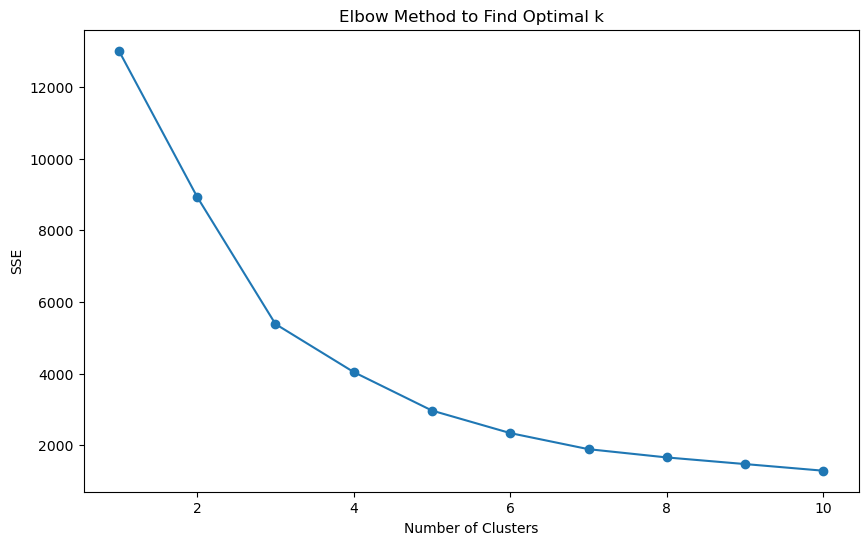

In [55]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method to Find Optimal k')
plt.show()

In [56]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

C:\Users\mgsma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


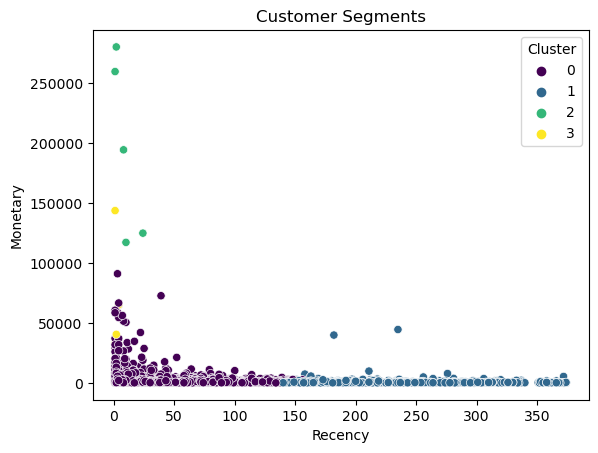

In [57]:
import seaborn as sns

sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Customer Segments')
plt.show()